# DRB Vizer json services
10/30/2015. Emilio Mayorga.   
Run with Emilio's "IOOS_test1" conda envioronment (recent versions of most packages)

http://www.wikiwatershed-vs.org examples:
- meta requests
  - http://www.wikiwatershed-vs.org/services/get_asset_info.php?opt=meta&asset_type=siso
  - http://www.wikiwatershed-vs.org/services/get_asset_info.php?opt=meta&asset_type=siso&asset_id=CRBCZO_WCC019
- data & recent_values requests
  - http://www.wikiwatershed-vs.org/services/get_asset_info.php?opt=data&asset_type=siso&asset_id=CRBCZO_WCC019&var_id=all&units_mode=v1
  - http://www.wikiwatershed-vs.org/services/get_asset_info.php?opt=data&asset_type=siso&asset_id=CRBCZO_WCC019&var_id=H1_WaterTemp
  - http://www.wikiwatershed-vs.org/services/get_asset_info.php?opt=recent_values&asset_type=siso&asset_id=CRBCZO_WCC019&var_id=H1_WaterTemp&units_mode=v2
- plot request
  - http://www.wikiwatershed-vs.org/services/get_asset_info.php?opt=plot&asset_type=siso&asset_id=USGS_01474500&var_id=H1_WaterTemp&range=30d&y_axis_mode=global

## Import packages and set up utility functions

In [1]:
import json
import requests
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
import datetime
import time
import calendar
import pytz
#from matplotlib.dates import date2num, num2date

utc_tz = pytz.utc

def epochsec_to_dt(epochsec):
    """ Return the datetime object for epoch seconds epochsec
    """
    dtnaive_dt = datetime.datetime.utcfromtimestamp(epochsec)
    dtutc_dt   = dtnaive_dt.replace(tzinfo=pytz.utc)
    return dtutc_dt

In [3]:
def get_measurement_byvarid(metaresult, var_id):
    return [e for e in metaresult['measurements'] if e['var_id'] == var_id][0]

## Service end point
For vizer instance that currently serves only the CRB and outlying areas, but will be expanded to the DRB to support the William Penn project needs.

In [4]:
vz_gai_url = "http://www.wikiwatershed-vs.org/services/get_asset_info.php"

## Meta info (metadata) requests
siso = "stationary in-situ observations" (eg, a river gage, weather stationg, moored buoy, etc)

In [5]:
meta_r = requests.get(vz_gai_url, params={'asset_type':'siso', 'opt':'meta'})
meta = meta_r.json()

In [6]:
meta.keys(), meta['success']

([u'result', u'success'], True)

In [7]:
type(meta['result']), len(meta['result'])

(list, 59)

In [8]:
# siso_id is the unique identifier (string type) for the station
siso_id_lst = [e['siso_id'] for e in meta['result']]

In [9]:
# Examine the response for the first station (index 0) in the returned list
meta['result'][0]['siso_id']

u'CRBCZO_WCC019'

In [10]:
meta['result'][0]

{u'data_timezone': u'US/Eastern',
 u'lat': 39.8588,
 u'lon': -75.7833,
 u'measurements': [{u'depth': u'0.0m',
   u'name': u'Conductivity',
   u'units': u'mS/cm',
   u'var_id': u'H1_Conductiv'},
  {u'depth': u'0.0m',
   u'name': u'Turbidity',
   u'units': u'NTU',
   u'var_id': u'H1_Turbidity'},
  {u'depth': u'0.0m',
   u'name': u'Water Level',
   u'units': u'cm',
   u'var_id': u'H2_WaterLevel'},
  {u'depth': u'0.0m',
   u'name': u'Water Temp.',
   u'units': u'\xb0C',
   u'var_id': u'H1_WaterTemp'}],
 u'name': u'CRBCZO_WCC019',
 u'platform_type': u'River Gauge',
 u'provider': u'CRBCZO',
 u'provider_url': u'https://criticalzone.org/christina/',
 u'siso_id': u'CRBCZO_WCC019',
 u'url': u'http://swrcsensors.dreamhosters.com/charts_main_SL031.php'}

### Examine all stations (siso assets) by first importing into a Pandas Dataframe

In [11]:
stations_rec = []
for sta in meta['result']:
    sta_rec = {key:sta[key] for key in ['siso_id', 'name', 'lat', 'lon', 
                                        'platform_type', 'provider']}
    stations_rec.append(sta_rec)

In [12]:
stations_df = pd.DataFrame.from_records(stations_rec)
stations_df.set_index('siso_id', inplace=True, verify_integrity=True)
stations_df.index.name = 'siso_id'
print len(stations_df)

59


In [13]:
stations_df.head(10)

,lat,lon,name,platform_type,provider
siso_id,,,,,
CRBCZO_WCC019,39.8588,-75.7833,CRBCZO_WCC019,River Gauge,CRBCZO
DEOS_DAGF,39.6695,-75.7503,DEOS DAGF,Weather Station,DEOS
DEOS_DBKB,39.3953,-75.6317,DEOS DBKB,Weather Station,DEOS
DEOS_DBUK1,39.8200,-75.7272,DEOS DBUK1,Weather Station,DEOS
DEOS_DCHI,39.7328,-75.5184,DEOS DCHI,Weather Station,DEOS
DEOS_DCLY,39.8092,-75.4556,DEOS DCLY,Weather Station,DEOS
DEOS_DDMV,39.6758,-75.6303,DEOS DDMV,Weather Station,DEOS
DEOS_DFHM,39.7099,-75.8386,DEOS DFHM,Weather Station,DEOS
DEOS_DGLW,39.6059,-75.7269,DEOS DGLW,Weather Station,DEOS


### Summaries (station counts) by *platform_type* and *provider*

In [14]:
stations_df.platform_type.value_counts()

River Gauge             30
Weather Station         19
Fixed Shore Platform     6
Well                     2
Soil Pit                 2
Name: platform_type, dtype: int64

In [15]:
stations_df.provider.value_counts()

USGS          27
DEOS          18
CRBCZO         5
NOS/CO-OPS     5
SWRC           3
USCRN          1
Name: provider, dtype: int64

## Request and examine one station

In [16]:
# USGS Schuylkill River at Philadelphia
siso_id = 'USGS_01474500'

### Meta info request

In [17]:
# (asset_id, a more generic descriptor for the unique id of any asset)
meta_r = requests.get(vz_gai_url, params={'asset_type':'siso', 'opt':'meta', 
                                          'asset_id':siso_id})

In [18]:
# use [0] to pull out the dict from the single-element list
metaresult = meta_r.json()['result'][0]  # ideally, should first test for success

In [19]:
# var_id is the unique identifier for a "measurement" (or variable)
[(d['var_id'], d['depth']) for d in metaresult['measurements']]

[(u'H1_Conductiv', u'-0.5m'),
 (u'H1_Discharge', u'0m'),
 (u'H1_Oxygen', u'-0.5m'),
 (u'H1_pH', u'-0.5m'),
 (u'A2_Rain', u'1m'),
 (u'H1_RiverStage', u'0m'),
 (u'H2_Turbidity', u'-0.5m'),
 (u'H1_WaterTemp', u'-0.5m')]

In [20]:
metaresult['name']

u'USGS 01474500'

### Data request

In [21]:
data_r = requests.get(vz_gai_url, params={'asset_type':'siso', 'opt':'data', 'units_mode': 'v1',
                                          'asset_id':siso_id, 'var_id':'all'})
data = data_r.json()

In [22]:
data['success'], len(data['result']), data['result'][0].keys(), len(data['result'][0]['data'])

(True, 8, [u'var_id', u'data'], 1825)

In [23]:
# Mapping of var_id string to 'result' list element index
var_ids = {e['var_id']:i for i,e in enumerate(data['result'])}
var_ids

{u'A2_Rain': 0,
 u'H1_Conductiv': 1,
 u'H1_Discharge': 2,
 u'H1_Oxygen': 3,
 u'H1_RiverStage': 5,
 u'H1_WaterTemp': 6,
 u'H1_pH': 4,
 u'H2_Turbidity': 7}

In [24]:
var_id = 'H1_Discharge'

In [25]:
get_measurement_byvarid(metaresult, var_id)

{u'depth': u'0m',
 u'name': u'Discharge',
 u'units': u'm\xb3/s',
 u'var_id': u'H1_Discharge'}

In [26]:
data['result'][var_ids[var_id]]['data'][-10:]

[{u'depth': u'0m', u'time': 1446183000, u'value': 265.6095},
 {u'depth': u'0m', u'time': 1446184800, u'value': 272.4055},
 {u'depth': u'0m', u'time': 1446186600, u'value': 274.6708},
 {u'depth': u'0m', u'time': 1446188400, u'value': 277.2193},
 {u'depth': u'0m', u'time': 1446190200, u'value': 277.2193},
 {u'depth': u'0m', u'time': 1446192000, u'value': 277.2193},
 {u'depth': u'0m', u'time': 1446193800, u'value': 277.2193},
 {u'depth': u'0m', u'time': 1446195600, u'value': 274.6708},
 {u'depth': u'0m', u'time': 1446197400, u'value': 272.4055},
 {u'depth': u'0m', u'time': 1446199200, u'value': 270.1402}]

In [27]:
# Pull out data time series for one variable based on var_id
# returns a list of dicts
data_lst = data['result'][var_ids[var_id]]['data']

In [28]:
data_df = pd.DataFrame.from_records(data_lst)

In [29]:
data_df.head()

,depth,time,value
0,0m,1440831600,18.3491
1,0m,1440833400,17.6129
2,0m,1440835200,17.6129
3,0m,1440837000,17.6129
4,0m,1440838800,16.8767


Create `dtutc` column with parsed datetime. Also, it's safer to rename the "value" column to something unlikely to conflict with pandas method names.

In [30]:
data_df['dtutc'] = data_df.time.map(lambda es: epochsec_to_dt(es))
data_df.set_index('dtutc', inplace=True, verify_integrity=True)
data_df.index.name = 'dtutc'
data_df = data_df.rename(columns={'value':var_id})

In [31]:
data_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1825 entries, 2015-08-29 07:00:00+00:00 to 2015-10-30 10:00:00+00:00
Data columns (total 3 columns):
depth           1825 non-null object
time            1825 non-null int64
H1_Discharge    1825 non-null float64
dtypes: float64(1), int64(1), object(1)
memory usage: 57.0+ KB


In [32]:
data_df.head()

,depth,time,H1_Discharge
dtutc,,,
2015-08-29 07:00:00+00:00,0m,1440831600,18.3491
2015-08-29 07:30:00+00:00,0m,1440833400,17.6129
2015-08-29 08:00:00+00:00,0m,1440835200,17.6129
2015-08-29 08:30:00+00:00,0m,1440837000,17.6129
2015-08-29 09:00:00+00:00,0m,1440838800,16.8767


In [33]:
data_df.describe()

,time,H1_Discharge
count,1.825000e+03,1825.000000
mean,1.443738e+09,37.350980
std,1.815587e+06,35.249309
min,1.440832e+09,11.921300
25%,1.441726e+09,17.612900
50%,1.444410e+09,25.088500
75%,1.445305e+09,37.944200
max,1.446199e+09,277.219300


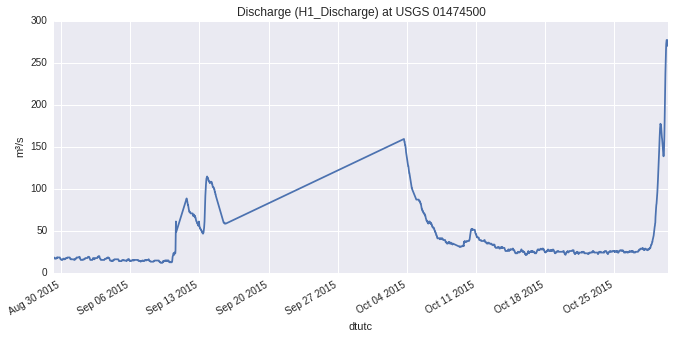

In [34]:
var_info = get_measurement_byvarid(metaresult, var_id)
title = "%s (%s) at %s" % (var_info['name'], var_id, metaresult['name'])
data_df[var_id].plot(title=title, figsize=[11,5])
plt.ylabel(var_info['units']);